<a href="https://colab.research.google.com/github/bansala/blogs/blob/master/imdb_sentiment_weak_supervision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NOTE: This is part of an upcoming book. PLEASE DO NOT SHARE until publication.

In [1]:
import numpy as np
import pandas as pd
import glob

import tensorflow as tf
import tensorflow_datasets as tfds

from bs4 import BeautifulSoup

# (Optional) GPU Setup

In [2]:
######## GPU CONFIGS FOR RTX 2070 ###############
## Please ignore if not training on GPU       ##
## this is important for running CuDNN on GPU ##

tf.keras.backend.clear_session() #- for easy reset of notebook state

# chck if GPU can be seen by TF
tf.config.list_physical_devices('GPU')
#tf.debugging.set_log_device_placement(True)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.experimental.set_memory_growth(gpus[0], True)
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)
###############################################

1 Physical GPUs, 1 Logical GPU


# Download Data

In [3]:
# Download file
!wget https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
# expand archive
!tar xvzf aclImdb_v1.tar.gz

Streaming output truncated to the last 5000 lines.
aclImdb/train/unsup/44982_0.txt
aclImdb/train/unsup/44981_0.txt
aclImdb/train/unsup/44980_0.txt
aclImdb/train/unsup/44979_0.txt
aclImdb/train/unsup/44978_0.txt
aclImdb/train/unsup/44977_0.txt
aclImdb/train/unsup/44976_0.txt
aclImdb/train/unsup/44975_0.txt
aclImdb/train/unsup/44974_0.txt
aclImdb/train/unsup/44973_0.txt
aclImdb/train/unsup/44972_0.txt
aclImdb/train/unsup/44971_0.txt
aclImdb/train/unsup/44970_0.txt
aclImdb/train/unsup/44969_0.txt
aclImdb/train/unsup/44968_0.txt
aclImdb/train/unsup/44967_0.txt
aclImdb/train/unsup/44966_0.txt
aclImdb/train/unsup/44965_0.txt
aclImdb/train/unsup/44964_0.txt
aclImdb/train/unsup/44963_0.txt
aclImdb/train/unsup/44962_0.txt
aclImdb/train/unsup/44961_0.txt
aclImdb/train/unsup/44960_0.txt
aclImdb/train/unsup/44959_0.txt
aclImdb/train/unsup/44958_0.txt
aclImdb/train/unsup/44957_0.txt
aclImdb/train/unsup/44956_0.txt
aclImdb/train/unsup/44955_0.txt
aclImdb/train/unsup/44954_0.txt
aclImdb/train/unsup/4

# Pre-Process Data into DataFrames

In [4]:
def load_reviews(path, columns=["filename", 'review']):
    assert len(columns) == 2
    l = list()
    for filename in glob.glob(path):
        # print(filename)
        with open(filename, 'r') as f:
            review = f.read()
            l.append((filename, review))
    return pd.DataFrame(l, columns=columns)

## Load Unsupervised Data

In [5]:
unsup_df = load_reviews("./aclImdb/train/unsup/*.txt")

In [6]:
unsup_df.describe()

,filename,review
count,50000,50000
unique,50000,49507
top,./aclImdb/train/unsup/18179_0.txt,"Am not from America, I usually watch this show..."
freq,1,5


## Load Training Set

In [7]:
def load_labelled_data(path, neg='/neg/', 
                       pos='/pos/', shuffle=True):
    neg_df = load_reviews(path + neg + "*.txt")
    pos_df = load_reviews(path + pos + "*.txt")
    neg_df['sentiment'] = 0
    pos_df['sentiment'] = 1
    df = pd.concat([neg_df, pos_df], axis=0)
    if shuffle:
        df = df.sample(frac=1, random_state=42)
    return df

In [8]:
train_df = load_labelled_data("./aclImdb/train/")

In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25000 entries, 6868 to 11154
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   filename   25000 non-null  object
 1   review     25000 non-null  object
 2   sentiment  25000 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 781.2+ KB


In [10]:
train_df.head()

,filename,review,sentiment
6868,./aclImdb/train//neg/1699_4.txt,"I'm somewhat of a fan of Lynche's work, so I w...",0
11516,./aclImdb/train//pos/8473_8.txt,This charmingly pleasant and tenderhearted seq...,1
9668,./aclImdb/train//neg/3877_4.txt,I just watched The Incredible Melting Man for ...,0
1140,./aclImdb/train//pos/9582_10.txt,After growing up in the gritty streets of Detr...,1
1518,./aclImdb/train//pos/12131_7.txt,The movie concerns about Philip(Leslie Howard)...,1


In [11]:
def fn_to_score(f):
    scr = f.split("/")[-1]  # get file name
    scr = scr.split(".")[0] # remove extension
    scr = int(scr.split("_")[-1]) #the score
    return scr

In [12]:
train_df['score'] = train_df.filename.apply(fn_to_score)

In [13]:
train_df.head()

,filename,review,sentiment,score
6868,./aclImdb/train//neg/1699_4.txt,"I'm somewhat of a fan of Lynche's work, so I w...",0,4
11516,./aclImdb/train//pos/8473_8.txt,This charmingly pleasant and tenderhearted seq...,1,8
9668,./aclImdb/train//neg/3877_4.txt,I just watched The Incredible Melting Man for ...,0,4
1140,./aclImdb/train//pos/9582_10.txt,After growing up in the gritty streets of Detr...,1,10
1518,./aclImdb/train//pos/12131_7.txt,The movie concerns about Philip(Leslie Howard)...,1,7


In [14]:
train_df.groupby('score', group_keys=False).\
    apply(lambda x: x.sample(min(len(x), 2), random_state=42))

,filename,review,sentiment,score
8975,./aclImdb/train//neg/4131_1.txt,This movie should be nominated for a new genre...,0,1
151,./aclImdb/train//neg/5143_1.txt,"Even if 99,99% of people that has seen this mo...",0,1
3958,./aclImdb/train//neg/7406_2.txt,"Well how was I suppose to know this was ""the"" ...",0,2
12219,./aclImdb/train//neg/8947_2.txt,"The book is fantastic, this film is not. There...",0,2
7341,./aclImdb/train//neg/878_3.txt,I can only believe that Garson Kanin must have...,0,3
5528,./aclImdb/train//neg/6776_3.txt,I wanted to love this movie. How could I not l...,0,3
3360,./aclImdb/train//neg/7030_4.txt,One of the cornerstones of low-budget cinema i...,0,4
7974,./aclImdb/train//neg/8526_4.txt,"I loved ""The Curse of Frankenstein"" so much th...",0,4
6965,./aclImdb/train//pos/6413_7.txt,"Robert De Niro, Cuba Gooding Jr., Hal Holbrook...",1,7
3355,./aclImdb/train//pos/6372_7.txt,"Beautiful to watch, but what would be the firs...",1,7


## Load Testing Set

In [15]:
test_df = load_labelled_data("./aclImdb/test/")

In [16]:
test_df.head()

,filename,review,sentiment
6868,./aclImdb/test//neg/12342_1.txt,This is the worst movie I have ever seen in my...,0
11516,./aclImdb/test//pos/8622_10.txt,I liked the movie but it should have been long...,1
9668,./aclImdb/test//neg/11158_2.txt,End of Days is one of the worst big-budget act...,0
1140,./aclImdb/test//pos/3918_8.txt,This is one of the best horror / suspense film...,1
1518,./aclImdb/test//pos/5028_8.txt,That pretty much sums it up ... corny. MacDowe...,1


In [17]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25000 entries, 6868 to 11154
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   filename   25000 non-null  object
 1   review     25000 non-null  object
 2   sentiment  25000 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 781.2+ KB


In [18]:
test_df.describe()

,sentiment
count,25000.00000
mean,0.50000
std,0.50001
min,0.00000
25%,0.00000
50%,0.50000
75%,1.00000
max,1.00000


# Create a Tokenizer

In [19]:
# we need to combine both training and unsupervised datasets
# while creating the subword tokenizer
text = unsup_df.review.to_list() + train_df.review.to_list()

In [20]:
len(text)

75000

In [21]:
text[:3]

['Best film this year. Indian Cinema at its best.If its said a "lost film by David Lean"-It deserves it. Vidhu Vinod Chopra-Two Thumbs up-This man is our hope.<br /><br />No words to describe this film. A modern day masterpiece. Vidhu Vinod Chopra\'s best. Breathtaking performances from Big B, Saif, Boman, Jackie, Sanjay, Vidya etc. Superb music and score and wonderful cinematography and locales not to forget the awe inspiring visual effects. In the years to come will be remembered as a CLASSIC. This is a poem on celluloid. Shakespeare nestling in the sands of Rajathan. This piece of work would have made Shakespeare smile broadly<br /><br />A must watch for Cinema Lovers. EKlavya-a Royal TREAT!',
 'I hate to be the one to tell you but this film is the sort of crap that Hollywood thinks is a film about "real" people ie the working class. And maybe the book, which I\'ve not read, is about a real working class town but the film they made from it is so predictable, so covered in self-congr

In [22]:
txt = [ BeautifulSoup(x).text for x in text ]

In [23]:
txt[:3]

['Best film this year. Indian Cinema at its best.If its said a "lost film by David Lean"-It deserves it. Vidhu Vinod Chopra-Two Thumbs up-This man is our hope.No words to describe this film. A modern day masterpiece. Vidhu Vinod Chopra\'s best. Breathtaking performances from Big B, Saif, Boman, Jackie, Sanjay, Vidya etc. Superb music and score and wonderful cinematography and locales not to forget the awe inspiring visual effects. In the years to come will be remembered as a CLASSIC. This is a poem on celluloid. Shakespeare nestling in the sands of Rajathan. This piece of work would have made Shakespeare smile broadlyA must watch for Cinema Lovers. EKlavya-a Royal TREAT!',
 'I hate to be the one to tell you but this film is the sort of crap that Hollywood thinks is a film about "real" people ie the working class. And maybe the book, which I\'ve not read, is about a real working class town but the film they made from it is so predictable, so covered in self-congratulatory ooze about its

In [24]:
# 8K vocab size
encoder = tfds.features.text.SubwordTextEncoder.\
                build_from_corpus(txt, 
                                  target_vocab_size=2**13)

In [25]:
encoder.save_to_file("imdb")

# Tokenize and Vectorize Data

In [26]:
# load encoder
imdb_encoder = tfds.features.text.SubwordTextEncoder.\
                load_from_file("imdb")

In [27]:
imdb_encoder.vocab_size

8266

## Process Training Dataset

In [28]:
# remove markup
cleaned_reviews = train_df.review.apply(lambda x: BeautifulSoup(x).text)

In [29]:
# convert pandas DF in to tf.Dataset
train = tf.data.Dataset.from_tensor_slices((cleaned_reviews.values, 
                                            train_df.sentiment.values))

In [30]:
for review, senti in train.take(2):
    print(review.numpy(), senti.numpy())

b"I'm somewhat of a fan of Lynche's work, so I was excited when I found this DVD. Unfortunately, I was very let down. It's a series of short cartoons which attempt to show a disturbing and disgusting sort of humor. The animation is very crude, no doubt done using Macromedia. Each cartoon has a big fat guy beating up his family and generally acting like a jerk to everyone he knows. For people who are not familiar with this vein of animation, they will probably be somewhat impressed by it. However, if you've spent much time on Newgrounds.com, like me, then these cartoons will be no different than any of the other stuff you've seen before. Many of the popular amateur artists on Newgrounds are doing much better work than what was shown on this DVD. If Lynch submitted this work to the website, then he would blend in perfectly with some of the better of Newgrounds artists. But, since I saw this on DVD, instead of on Newgrounds, I give it a 4/10, instead of a 7/10, as I would have otherwise. 

In [31]:
# transformation functions to be used with the dataset
from tensorflow.keras.preprocessing import sequence

def encode_pad_transform(sample):
    encoded = imdb_encoder.encode(sample.numpy())
    pad = sequence.pad_sequences([encoded], padding='post', 
                                 maxlen=150)
    return np.array(pad[0], dtype=np.int64)  


def encode_tf_fn(sample, label):
    encoded = tf.py_function(encode_pad_transform, 
                                       inp=[sample], 
                                       Tout=(tf.int64))
    encoded.set_shape([None])
    label.set_shape([])
    return encoded, label

In [32]:
# test the transformation on a small subset
subset = train.take(10)
tst = subset.map(encode_tf_fn)

In [33]:
for review, label in tst.take(1):
    print(review.numpy(), label.numpy())
    print(imdb_encoder.decode(review))

[  48  214    2  141  184 6041 8042   92   31   79  381   85  118    6
    1  103 1372  147 8049  113  166 1034    3 2905    6    1 2398 5695
 8042 2757    8   21 3983 3436    8   24  568   91  189  263   85   67
   15 1072   21   13 1148    3  152 5840 8042  773 1595  438   13  263
    7    1 5472 5485    2  141   39   66 6301 8042   10 2150   19   58
    6    1  189    6 3983 3436    8 2757 8125    3 1104    2  330   11
  284   13   21 1148    2  638    6   21 3983 3436 8125    2   11  250
   14    4 8062 8057  286    2  638    6    4 8065 8057  286    2   17
   11   66   27  791 2542    3 1421 6041 8042   24 1978   20    1  628
 4120    2   22   19    4  727   48  933 5840 8042   21   35    2   11
 1934  189  907  276   10   96    5   10 5614 8056] 0
like me, then these cartoons will be no different than any of the other stuff you've seen before. Many of the popular amateur artists on Newgrounds are doing much better work than what was shown on this DVD. If Lynch submitted this work

In [34]:
encoded_train = train.map(encode_tf_fn,
                        num_parallel_calls=tf.data.experimental.AUTOTUNE)

## Process Testing Dataset

In [83]:
# remove markup
cleaned_reviews = test_df.review.apply(lambda x: BeautifulSoup(x).text)

In [36]:
# convert pandas DF in to tf.Dataset
test = tf.data.Dataset.from_tensor_slices((cleaned_reviews.values, 
                                            test_df.sentiment.values))

In [37]:
encoded_test = test.map(encode_tf_fn,
                        num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Baseline model

In [38]:
# Length of the vocabulary 
vocab_size = imdb_encoder.vocab_size 

# Number of RNN units
rnn_units = 64

# Embedding size
embedding_dim = 64

#batch size
BATCH_SIZE=100

In [39]:
from tensorflow.keras.layers import Embedding, LSTM, \
                                    Bidirectional, Dense,\
                                    Dropout
            

dropout=0.2
def build_model_bilstm(vocab_size, embedding_dim, rnn_units, batch_size):
  model = tf.keras.Sequential([
    Embedding(vocab_size, embedding_dim, mask_zero=True,
                              batch_input_shape=[batch_size, None]),
    Bidirectional(LSTM(rnn_units, return_sequences=True, 
                      dropout=dropout)),
    Dropout(dropout),
    Bidirectional(tf.keras.layers.LSTM(rnn_units, dropout=dropout)),
    Dropout(dropout),
    Dense(1, activation='sigmoid')
  ])
  return model

In [56]:
bilstm = build_model_bilstm(
  vocab_size = vocab_size,
  embedding_dim=embedding_dim,
  rnn_units=rnn_units,
  batch_size=BATCH_SIZE)

bilstm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (100, None, 64)           529024    
_________________________________________________________________
bidirectional (Bidirectional (100, None, 128)          66048     
_________________________________________________________________
dropout (Dropout)            (100, None, 128)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (100, 128)                98816     
_________________________________________________________________
dropout_1 (Dropout)          (100, 128)                0         
_________________________________________________________________
dense (Dense)                (100, 1)                  129       
Total params: 694,017
Trainable params: 694,017
Non-trainable params: 0
__________________________________________________

In [57]:
bilstm.compile(loss='binary_crossentropy', 
             optimizer='adam', 
             metrics=['accuracy', 'Precision', 'Recall'])

In [58]:
encoded_train_batched = encoded_train.batch(BATCH_SIZE).prefetch(1000)

In [59]:
bilstm.fit(encoded_train_batched, epochs=15)

Epoch 1/15
250/250 [==============================] - 27s 108ms/step - loss: 0.4528 - accuracy: 0.7695 - precision: 0.7951 - recall: 0.7260
Epoch 2/15
250/250 [==============================] - 29s 115ms/step - loss: 0.2802 - accuracy: 0.8882 - precision: 0.8887 - recall: 0.8875
Epoch 3/15
250/250 [==============================] - 29s 115ms/step - loss: 0.2221 - accuracy: 0.9156 - precision: 0.9153 - recall: 0.9159
Epoch 4/15
250/250 [==============================] - 29s 115ms/step - loss: 0.1703 - accuracy: 0.9379 - precision: 0.9377 - recall: 0.9382
Epoch 5/15
250/250 [==============================] - 29s 115ms/step - loss: 0.1279 - accuracy: 0.9513 - precision: 0.9508 - recall: 0.9518
Epoch 6/15
250/250 [==============================] - 29s 116ms/step - loss: 0.1129 - accuracy: 0.9574 - precision: 0.9558 - recall: 0.9593
Epoch 7/15
250/250 [==============================] - 29s 116ms/step - loss: 0.0922 - accuracy: 0.9653 - precision: 0.9650 - recall: 0.9657
Epoch 8/15
250/250 [

In [60]:
bilstm.evaluate(encoded_test.batch(BATCH_SIZE))

250/250 [==============================] - 26s 104ms/step - loss: 1.2759 - accuracy: 0.8166 - precision: 0.7979 - recall: 0.8479


[1.2759424448013306,
 0.8165599703788757,
 0.7978771328926086,
 0.8479200005531311]

# Snorkel Labelling

In [40]:
!pip install snorkel

     |████████████████████████████████| 153kB 6.5MB/s 
     |████████████████████████████████| 6.7MB 13.2MB/s 
     |████████████████████████████████| 1.8MB 43.3MB/s 
     |████████████████████████████████| 3.8MB 38.8MB/s 
  Created wheel for networkx: filename=networkx-2.3-py2.py3-none-any.whl size=1556408 sha256=5f4d2cd8d631e48d33c3b90460b8389026c6560ac5fc6a0f525fde2415bf6080
  Stored in directory: /root/.cache/pip/wheels/de/63/64/3699be2a9d0ccdb37c7f16329acf3863fd76eda58c39c737af
Successfully built networkx
ERROR: tensorflow 2.3.0 has requirement tensorboard<3,>=2.3.0, but you'll have tensorboard 1.15.0 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1
  Found existing installation: networkx 2.4
    Uninstalling networkx-2.4:
      Succe

In [ ]:
POSITIVE = 1
NEGATIVE = 0
ABSTAIN = -1

In [42]:
from snorkel.labeling.lf import labeling_function

In [43]:
@labeling_function()
def time_waste(x):
    if not isinstance(x.review, str):
        return ABSTAIN
    ex1 = "time waste"
    ex2 = "waste of time"
    if ex1 in x.review.lower() or ex2 in x.review.lower():
        return NEGATIVE
    return ABSTAIN

In [44]:
# Now lets print some reviews with positive and negative labels to
# get ideas for labelling functions

In [45]:
neg = train_df[train_df.sentiment==0].sample(n=5, random_state=42)

In [46]:
for x in neg.review.tolist():
    print( x)

This may very well be the worst movie I'll see if I live to be 100. I think a group of first-graders could have come up with better plot lines as a class project than this. I'm dumber for having watched it, and God have mercy on the souls who were paid to produce this film.<br /><br />And after I finally turned it off, I actually had the urge to vomit.<br /><br />No one had a clue about photography when made this. No one had a clue about acting. No one had a clue about just about anything.<br /><br />I can't believe F/X shows this crap on occasion. The only time I had seen it was on one of the Starz! channels - not even the main one. And it was on at about 3 a.m. at that.
OK this movie was made for one reason and one reason only TO MAKE MONEY!!The producers obviously didn't care about killing a classic horror movie. I knew this movie would suck as soon as it was going to be a pg-13 how many pg-13 slashers movies have turned out to be good? Thats like asking how many women have been on 

In [47]:
@labeling_function()
def atrocious(x):
    if not isinstance(x.review, str):
        return ABSTAIN
    ex1 = "atrocious"
    if ex1 in x.review.lower():
        return NEGATIVE
    return ABSTAIN

@labeling_function()
def crap(x):
    if not isinstance(x.review, str):
        return ABSTAIN
    ex1 = "crap"
    if ex1 in x.review.lower():
        return NEGATIVE
    return ABSTAIN

@labeling_function()
def garbage(x):
    if not isinstance(x.review, str):
        return ABSTAIN
    ex1 = "garbage"
    if ex1 in x.review.lower():
        return NEGATIVE
    return ABSTAIN


@labeling_function()
def terrible(x):
    if not isinstance(x.review, str):
        return ABSTAIN
    ex1 = "terrible"
    if ex1 in x.review.lower():
        return NEGATIVE
    return ABSTAIN

@labeling_function()
def piece_of(x):
    if not isinstance(x.review, str):
        return ABSTAIN
    ex1 = {"piece", "of", "junk"}
    st_rvw = set(x.review.lower().split())
    if st_rvw.issuperset(ex1):
        return NEGATIVE
    return ABSTAIN

@labeling_function()
def woefully_miscast(x):
    if not isinstance(x.review, str):
        return ABSTAIN
    ex1 = "woeful"
    ex2 = "miscast"
    if ex1 in x.review.lower() or ex2 in x.review.lower():
        return NEGATIVE
    return ABSTAIN

@labeling_function()
def bad_acting(x):
    if not isinstance(x.review, str):
        return ABSTAIN
    ex1 = "bad"
    ex2 = "acting"
    if ex1 in x.review.lower() and ex2 in x.review.lower():
        return NEGATIVE
    return ABSTAIN

@labeling_function()
def cheesy_dull(x):
    if not isinstance(x.review, str):
        return ABSTAIN
    ex1 = "cheesy"
    ex2 = "dull"
    if ex1 in x.review.lower() or ex2 in x.review.lower():
        return NEGATIVE
    return ABSTAIN
    
@labeling_function()
def disappoint(x):
    if not isinstance(x.review, str):
        return ABSTAIN
    ex1 = "disappoint"
    if ex1 in x.review.lower():
        return NEGATIVE
    return ABSTAIN

@labeling_function()
def unsatisfied(x):
    if not isinstance(x.review, str):
        return ABSTAIN
    ex1 = "unsatisf"  # unsatisfactory, unsatisfied
    if ex1 in x.review.lower():
        return NEGATIVE
    return ABSTAIN

@labeling_function()
def ridiculous(x):
    if not isinstance(x.review, str):
        return ABSTAIN
    ex1 = "ridiculous"  
    if ex1 in x.review.lower():
        return NEGATIVE
    return ABSTAIN

neg_lfs = [atrocious, terrible, piece_of, woefully_miscast, bad_acting,
          cheesy_dull, disappoint, crap, garbage, unsatisfied,
          ridiculous]

In [48]:
# Now lets try some positive examples
pos = train_df[train_df.sentiment==1].sample(n=5, random_state=42)
for x in pos.review.tolist():
    print(x)

I grew up in Royersford, Pa. The town where Jerry's market was. I remember my whole family going out to watch the filming. I remember a guy showing the "Blob" to me and my brothers in a bucket. I also would like to share that my mother was in the movie. Her hair style was the same as Aneta Corsaut's and she was ill one evening and they saw my mom and asked her to sit in the car with Steve Mcqueen for some shots from behind. They payed her $25.00 and gave her a story to tell until she passed away this past August. My mom was not a teenager and she was a few months from giving birth to my little sister.
"Scoop" is also the name of a late-Thirties Evelyn Waugh novel, and Woody Allen's new movie, though set today, has a nostalgic charm and simplicity. It hasn't the depth of characterization, intense performances, suspense or shocking final frisson of Allen's penultimate effort "Match Point," (argued by many, including this reviewer, to be a strong return to form) but "Scoop" does closely r

In [49]:
import re

@labeling_function()
def classic(x):
    if not isinstance(x.review, str):
        return ABSTAIN
    ex1 = "a classic"
    if ex1 in x.review.lower():
        return POSITIVE
    return ABSTAIN

@labeling_function()
def must_watch(x):
    if not isinstance(x.review, str):
        return ABSTAIN
    ex1 = "must watch"
    if ex1 in x.review.lower():
        return POSITIVE
    return ABSTAIN

@labeling_function()
def oscar(x):
    if not isinstance(x.review, str):
        return ABSTAIN
    ex1 = "oscar nominated"
    if ex1 in x.review.lower() :
        return POSITIVE
    return ABSTAIN

@labeling_function()
def love(x):
    if not isinstance(x.review, str):
        return ABSTAIN
    st_rvw = set(x.review.lower().split())
    ex1 = {"love", "the", "movie"}
    if st_rvw.issuperset(ex1) :
        return POSITIVE
    return ABSTAIN

@labeling_function()
def great_entertainment(x):
    if not isinstance(x.review, str):
        return ABSTAIN
    st_rvw = set(x.review.lower().split())
    ex1 = {"great", "entertainment"}
    if st_rvw.issuperset(ex1) :
        return POSITIVE
    return ABSTAIN

@labeling_function()
def very_entertaining(x):
    if not isinstance(x.review, str):
        return ABSTAIN
    ex1 = "very entertaining"
    if ex1 in x.review.lower() :
        return POSITIVE
    return ABSTAIN

@labeling_function()
def amazing(x):
    if not isinstance(x.review, str):
        return ABSTAIN
    ex1 = "amazing"
    if ex1 in x.review.lower():
        return POSITIVE
    return ABSTAIN

@labeling_function()
def brilliant(x):
    if not isinstance(x.review, str):
        return ABSTAIN
    ex1 = "brillant"
    if ex1 in x.review.lower():
        return POSITIVE
    return ABSTAIN

@labeling_function()
def fantastic(x):
    if not isinstance(x.review, str):
        return ABSTAIN
    ex1 = "fantastic"
    if ex1 in x.review.lower():
        return POSITIVE
    return ABSTAIN

@labeling_function()
def awesome(x):
    if not isinstance(x.review, str):
        return ABSTAIN
    ex1 = "awesome"
    if ex1 in x.review.lower():
        return POSITIVE
    return ABSTAIN

@labeling_function()
def great_acting(x):
    if not isinstance(x.review, str):
        return ABSTAIN
    ex1 = "(great|awesome|amazing|fantastic|excellent) act"
    if re.search(ex1, x.review.lower()):
        return POSITIVE
    return ABSTAIN

@labeling_function()
def great_direction(x):
    if not isinstance(x.review, str):
        return ABSTAIN
    ex1 = "(great|awesome|amazing|fantastic|excellent) direction"
    if re.search(ex1, x.review.lower()):
        return POSITIVE
    return ABSTAIN

@labeling_function()
def great_story(x):
    if not isinstance(x.review, str):
        return ABSTAIN
    ex1 = "(great|awesome|amazing|fantastic|excellent|dramatic) (script|story)"
    if re.search(ex1, x.review.lower()):
        return POSITIVE
    return ABSTAIN

@labeling_function()
def favourite(x):
    if not isinstance(x.review, str):
        return ABSTAIN
    ex1 = "my favourite"
    if ex1 in x.review.lower():
        return POSITIVE
    return ABSTAIN

pos_lfs = [classic, must_watch, oscar, love, great_entertainment,  
           very_entertaining, amazing, brilliant, fantastic, awesome, 
           great_acting, great_direction, great_story, favourite]

In [50]:
from snorkel.labeling.model import LabelModel
from snorkel.labeling import PandasLFApplier

In [51]:
# set of labeling functions
lfs = neg_lfs + pos_lfs

In [52]:
# Apply the LFs to the unlabeled training data
applier = PandasLFApplier(lfs)

# lets take a sample of 100 records from training set
lf_train = train_df.sample(n=1000, random_state=42)
L_train = applier.apply(lf_train)

100%|██████████| 1000/1000 [00:01<00:00, 678.49it/s]


In [53]:
# Train the label model and compute the training labels
label_model = LabelModel(cardinality=2, verbose=True)
label_model.fit(L_train, n_epochs=500, log_freq=50, seed=123)
lf_train["snorkel"] = label_model.predict(L=L_train, tie_break_policy="abstain")

In [54]:
from snorkel.labeling import LFAnalysis

LFAnalysis(L=L_train, lfs=lfs).lf_summary()

,j,Polarity,Coverage,Overlaps,Conflicts
atrocious,0,[0],0.007,0.006,0.003
terrible,1,[0],0.042,0.025,0.009
piece_of,2,[0],0.002,0.001,0.000
woefully_miscast,3,[0],0.005,0.004,0.001
bad_acting,4,[0],0.090,0.045,0.019
cheesy_dull,5,[0],0.037,0.016,0.007
disappoint,6,[0],0.062,0.027,0.012
crap,7,[0],0.049,0.026,0.007
garbage,8,[0],0.015,0.008,0.001
unsatisfied,9,[],0.000,0.000,0.000


In [55]:
pred_lfs = lf_train[lf_train.snorkel > -1]
pred_lfs.describe()

,sentiment,score,snorkel
count,417.000000,417.000000,417.000000
mean,0.410072,4.848921,0.287770
std,0.492437,3.546898,0.453267
min,0.000000,1.000000,0.000000
25%,0.000000,1.000000,0.000000
50%,0.000000,3.000000,0.000000
75%,1.000000,9.000000,1.000000
max,1.000000,10.000000,1.000000


In [56]:
pred_mistake = pred_lfs[pred_lfs.sentiment != pred_lfs.snorkel]

In [57]:
pred_mistake.describe()

,sentiment,score,snorkel
count,117.000000,117.000000,117.000000
mean,0.717949,7.000000,0.282051
std,0.451934,3.167725,0.451934
min,0.000000,1.000000,0.000000
25%,0.000000,4.000000,0.000000
50%,1.000000,8.000000,0.000000
75%,1.000000,10.000000,1.000000
max,1.000000,10.000000,1.000000


In [58]:
pred_mistake.head()

,filename,review,sentiment,score,snorkel
2201,./aclImdb/train//pos/11917_8.txt,"Yeah, the archetype of a simple but inspiratio...",1,8,0
11390,./aclImdb/train//neg/4963_4.txt,turned out to be another failed attempt by the...,0,4,1
12036,./aclImdb/train//neg/221_4.txt,I was gifted with this movie as it had such a ...,0,4,1
9279,./aclImdb/train//neg/3822_2.txt,To be a Buster Keaton fan is to have your hear...,0,2,1
4768,./aclImdb/train//pos/1740_8.txt,This movie was not so much promoted here in Gr...,1,8,0


In [59]:
for x in pred_mistake.head().review.tolist():
    print("**" + x)

**Yeah, the archetype of a simple but inspirational movie. The very end when the entire crowd in the stadium gets up and the people raise their hands gives me a chill whenever I see it. That's just brilliant. Joseph is wonderful as the lonely and sad kid who has so far been disappointed by anyone and anything in his life. The way he interacts with Danny Glover and tries to make him believe in the magic and the angels is funny and exhilarating. A very nice family movie with - I concede - a rather corny happy end. But hey, it doesn't really matter, the movie retains its basic quality by the good acting and the inspirational themes.
**turned out to be another failed attempt by the laughable sci-fi channel. i am not sure who wrote the script, and interpreted the poem, but i am sure it was by some 17 year old teen who thought it would be awesome to a have a scoped crossbow in the movie. AAAAAAAH! when i saw that part, I lost all hope. Then...they set off for heorot in a what looks to be the

## Now train on entire training data set

In [60]:
L_train_full = applier.apply(train_df)
label_model = LabelModel(cardinality=2, verbose=True)
label_model.fit(L_train_full, n_epochs=500, log_freq=50, seed=123)
train_df["snorkel"] = label_model.predict(L=L_train_full, 
                                          tie_break_policy="abstain")

100%|██████████| 25000/25000 [00:35<00:00, 699.15it/s]


In [61]:
pred_lfs = train_df[train_df.snorkel > -1]
pred_lfs.describe()

,sentiment,score,snorkel
count,11159.000000,11159.000000,11159.000000
mean,0.429160,5.007707,0.359889
std,0.494978,3.502737,0.479989
min,0.000000,1.000000,0.000000
25%,0.000000,2.000000,0.000000
50%,0.000000,4.000000,0.000000
75%,1.000000,9.000000,1.000000
max,1.000000,10.000000,1.000000


In [62]:
pred_mistake = pred_lfs[pred_lfs.sentiment != pred_lfs.snorkel]
pred_mistake.describe()

,sentiment,score,snorkel
count,2627.000000,2627.000000,2627.000000
mean,0.647126,6.352493,0.352874
std,0.477955,3.125917,0.477955
min,0.000000,1.000000,0.000000
25%,0.000000,3.000000,0.000000
50%,1.000000,7.000000,0.000000
75%,1.000000,9.000000,1.000000
max,1.000000,10.000000,1.000000


In [63]:
label_model_acc = label_model.score(L=L_train_full, Y=train_df.sentiment, 
                                tie_break_policy="abstain")["accuracy"]
print(f"{'Label Model Accuracy:':<25} {label_model_acc * 100:.1f}%")

Label Model Accuracy:     76.5%


In [64]:
from snorkel.labeling.model import MajorityLabelVoter

majority_model = MajorityLabelVoter()
preds_train = majority_model.predict(L=L_train_full)

In [65]:
majority_acc = majority_model.score(L=L_train_full, Y=train_df.sentiment, 
                                tie_break_policy="abstain")["accuracy"]
print(f"{'Majority Vote Accuracy:':<25} {majority_acc * 100:.1f}%")

Majority Vote Accuracy:   78.5%


In [66]:
from snorkel.labeling import LFAnalysis

LFAnalysis(L=L_train_full, lfs=lfs).lf_summary()

,j,Polarity,Coverage,Overlaps,Conflicts
atrocious,0,[0],0.00816,0.00584,0.00132
terrible,1,[0],0.05356,0.03168,0.01072
piece_of,2,[0],0.00084,0.00068,0.00020
woefully_miscast,3,[0],0.00848,0.00480,0.00164
bad_acting,4,[0],0.08748,0.04924,0.01736
cheesy_dull,5,[0],0.05136,0.02716,0.01012
disappoint,6,[0],0.06812,0.03136,0.01548
crap,7,[0],0.04784,0.02544,0.00896
garbage,8,[0],0.01692,0.00992,0.00272
unsatisfied,9,[0],0.00388,0.00188,0.00068


In [ ]:
2374/8650  # previous version with fewer function

0.2744508670520231

In [ ]:
2590/10247 # without time pass

0.2527569044598419

## Label the unsupervised dataset

In [67]:
# Apply the LFs to the unlabeled training data
applier = PandasLFApplier(lfs)

# now lets apply on the unsuperisved dataset
L_train_unsup = applier.apply(unsup_df)

100%|██████████| 50000/50000 [01:21<00:00, 614.83it/s]


In [68]:
label_model = LabelModel(cardinality=2, verbose=True)
label_model.fit(L_train_unsup, n_epochs=500, log_freq=100, seed=42)
unsup_df["snorkel"] = label_model.predict(L=L_train_unsup, 
                                          tie_break_policy="abstain")

In [69]:
pred_unsup_lfs = unsup_df[unsup_df.snorkel > -1]
pred_unsup_lfs.describe()

,snorkel
count,22233.000000
mean,0.359151
std,0.479762
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [70]:
from snorkel.labeling import LFAnalysis

LFAnalysis(L=L_train_unsup, lfs=lfs).lf_summary()

,j,Polarity,Coverage,Overlaps,Conflicts
atrocious,0,[0],0.00734,0.00496,0.00148
terrible,1,[0],0.05400,0.03188,0.01024
piece_of,2,[0],0.00072,0.00046,0.00008
woefully_miscast,3,[0],0.00758,0.00384,0.00160
bad_acting,4,[0],0.08520,0.04734,0.01724
cheesy_dull,5,[0],0.05312,0.02882,0.01088
disappoint,6,[0],0.06914,0.03188,0.01586
crap,7,[0],0.04880,0.02694,0.00980
garbage,8,[0],0.01652,0.00972,0.00304
unsatisfied,9,[0],0.00370,0.00186,0.00076


In [71]:
# rename snorkel to sentiment for concatentation to the training dataset
p2 = pred_unsup_lfs.rename(columns={"snorkel": "sentiment"})
p2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22233 entries, 0 to 49991
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   filename   22233 non-null  object
 1   review     22233 non-null  object
 2   sentiment  22233 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 694.8+ KB


## Vectorize unsupervised reviews

In [72]:
# remove markup
cleaned_unsup_reviews = p2.review.apply(lambda x: BeautifulSoup(x).text)

In [73]:
snorkel_reviews = pd.concat((cleaned_reviews, cleaned_unsup_reviews))

In [74]:
snorkel_reviews.describe()

count                                                 47233
unique                                                46673
top       Am not from America, I usually watch this show...
freq                                                      6
Name: review, dtype: object

In [75]:
snorkel_labels = pd.concat((train_df.sentiment, p2.sentiment))
snorkel_labels.describe()

count    47233.000000
mean         0.433701
std          0.495590
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: sentiment, dtype: float64

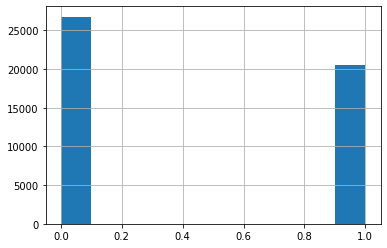

In [76]:
snorkel_labels.hist()

In [77]:
# convert pandas DF in to tf.Dataset
snorkel_train = tf.data.Dataset.from_tensor_slices((snorkel_reviews.values, 
                                            snorkel_labels.values))

In [78]:
encoded_snorkel_train = snorkel_train.map(encode_tf_fn,
                            num_parallel_calls=tf.data.experimental.AUTOTUNE)

## Supervised model for snorkel data

In [84]:
bilstm2 = build_model_bilstm(
  vocab_size = vocab_size,
  embedding_dim=embedding_dim,
  rnn_units=rnn_units,
  batch_size=BATCH_SIZE)

bilstm2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (100, None, 64)           529024    
_________________________________________________________________
bidirectional_2 (Bidirection (100, None, 128)          66048     
_________________________________________________________________
dropout_2 (Dropout)          (100, None, 128)          0         
_________________________________________________________________
bidirectional_3 (Bidirection (100, 128)                98816     
_________________________________________________________________
dropout_3 (Dropout)          (100, 128)                0         
_________________________________________________________________
dense_1 (Dense)              (100, 1)                  129       
Total params: 694,017
Trainable params: 694,017
Non-trainable params: 0
________________________________________________

In [85]:
bilstm2.compile(loss='binary_crossentropy', 
             optimizer='adam', 
             metrics=['accuracy', 'Precision', 'Recall'])

In [86]:
encoded_snorkel_batched = encoded_snorkel_train.batch(BATCH_SIZE, 
                                        drop_remainder=True).shuffle(47000)

In [87]:
bilstm2.fit(encoded_snorkel_batched, epochs=15)

Epoch 1/15
472/472 [==============================] - 65s 138ms/step - loss: 0.4778 - accuracy: 0.7675 - precision: 0.7651 - recall: 0.6694
Epoch 2/15
472/472 [==============================] - 65s 139ms/step - loss: 0.3612 - accuracy: 0.8471 - precision: 0.8241 - recall: 0.8231
Epoch 3/15
472/472 [==============================] - 61s 130ms/step - loss: 0.3055 - accuracy: 0.8763 - precision: 0.8601 - recall: 0.8537
Epoch 4/15
472/472 [==============================] - 63s 134ms/step - loss: 0.2431 - accuracy: 0.9043 - precision: 0.8923 - recall: 0.8863
Epoch 5/15
472/472 [==============================] - 65s 137ms/step - loss: 0.1930 - accuracy: 0.9256 - precision: 0.9154 - recall: 0.9128
Epoch 6/15
472/472 [==============================] - 64s 135ms/step - loss: 0.1510 - accuracy: 0.9433 - precision: 0.9369 - recall: 0.9321
Epoch 7/15
472/472 [==============================] - 65s 138ms/step - loss: 0.1191 - accuracy: 0.9549 - precision: 0.9480 - recall: 0.9480
Epoch 8/15
472/472 [

In [88]:
bilstm2.evaluate(encoded_test.batch(BATCH_SIZE))

250/250 [==============================] - 33s 133ms/step - loss: 0.0125 - accuracy: 0.9966 - precision: 0.9958 - recall: 0.9974


[0.012452387250959873,
 0.9966400265693665,
 0.9958466291427612,
 0.997439980506897]

In [111]:
bilstm2.fit(encoded_snorkel_batched, epochs=10)

Epoch 1/10
472/472 [==============================] - 57s 122ms/step - loss: 0.0821 - accuracy: 0.9691 - precision: 0.9650 - recall: 0.9637
Epoch 2/10
472/472 [==============================] - 58s 122ms/step - loss: 0.0922 - accuracy: 0.9647 - precision: 0.9602 - recall: 0.9584
Epoch 3/10
472/472 [==============================] - 58s 122ms/step - loss: 0.0846 - accuracy: 0.9666 - precision: 0.9618 - recall: 0.9611
Epoch 4/10
472/472 [==============================] - 58s 123ms/step - loss: 0.0755 - accuracy: 0.9719 - precision: 0.9686 - recall: 0.9665
Epoch 5/10
472/472 [==============================] - 58s 122ms/step - loss: 0.0770 - accuracy: 0.9707 - precision: 0.9672 - recall: 0.9652
Epoch 6/10
472/472 [==============================] - 58s 124ms/step - loss: 0.0653 - accuracy: 0.9760 - precision: 0.9739 - recall: 0.9706
Epoch 7/10
472/472 [==============================] - 58s 123ms/step - loss: 0.0579 - accuracy: 0.9785 - precision: 0.9759 - recall: 0.9746
Epoch 8/10
472/472 [

In [112]:
bilstm2.evaluate(encoded_test.batch(BATCH_SIZE))

250/250 [==============================] - 24s 97ms/step - loss: 0.3283 - accuracy: 0.9127 - precision: 0.9684 - recall: 0.8533


[0.3282628655433655,
 0.9127200245857239,
 0.9684038758277893,
 0.8532800078392029]

# BERT Model with Snorkel Labelled Data

In [113]:
# copy from Chapter 3
# Maybe will do

In [114]:
tf.__version__

'2.3.0'